In [1]:
if 'google.colab' in str(get_ipython()):
# @title установка драйверов
  !apt-get update > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
  !apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
  !apt-get install x11-utils > /dev/null 2>&1
  !apt-get install xvfb > /dev/null 2>&1

In [2]:
%%capture
if 'google.colab' in str(get_ipython()):
# @title установка библиотек

  %pip install rarfile --quiet
  %pip install ale-py --quiet
  %pip install gym[box2d] --quiet
  %pip install pyvirtualdisplay --quiet
  %pip install pyglet --quiet
  %pip install pygame --quiet
  %pip install minigrid --quiet
  %pip install -q swig --quiet
  %pip install -q gymnasium[box2d] --quiet
  %pip install 'minigrid<=2.1.1' --quiet
  %pip3 install box2d-py --quiet

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gymnasium as gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [4]:
# @title Вспомогательная функция вывода в виртуальный дисплей

from IPython.display import HTML
from base64 import b64encode
os.environ['PYVIRTUALDISPLAY_DISPLAYFD'] = '0'
from pyvirtualdisplay import Display

# create the directory to store the video(s)
os.makedirs("./video", exist_ok=True)

display = Display(visible=False, size=(800, 600))
_ = display.start()

"""
Функция позволяет записывать видео из gym и отображать его.
Чтобы включить видео, просто выполните "env = wrap_env(env)""
"""
def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Длину эпизода не ограничиваю
Сделал экспоненциальный распад для learning rate и эпсилон, вроде получилось получше чем с константойм линейным распадом. С забыванием играться терпения не хватило.
C action_mask тоже не разобрался, очень странные разультаты получились, поэтому за немодифицирующие действия штрафовал дополнительно. Не знаю, корректно это или нет, но результат дает

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




Finished training



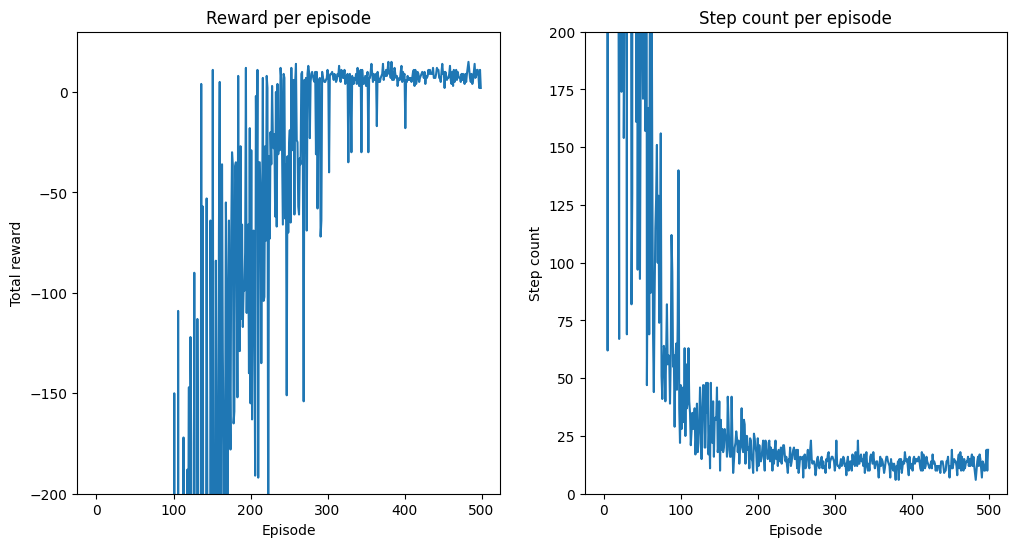

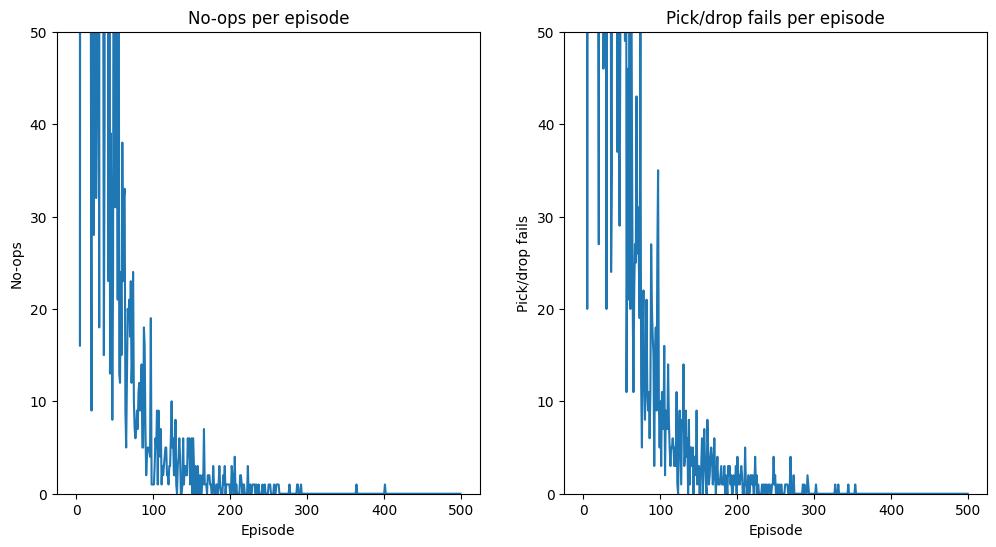

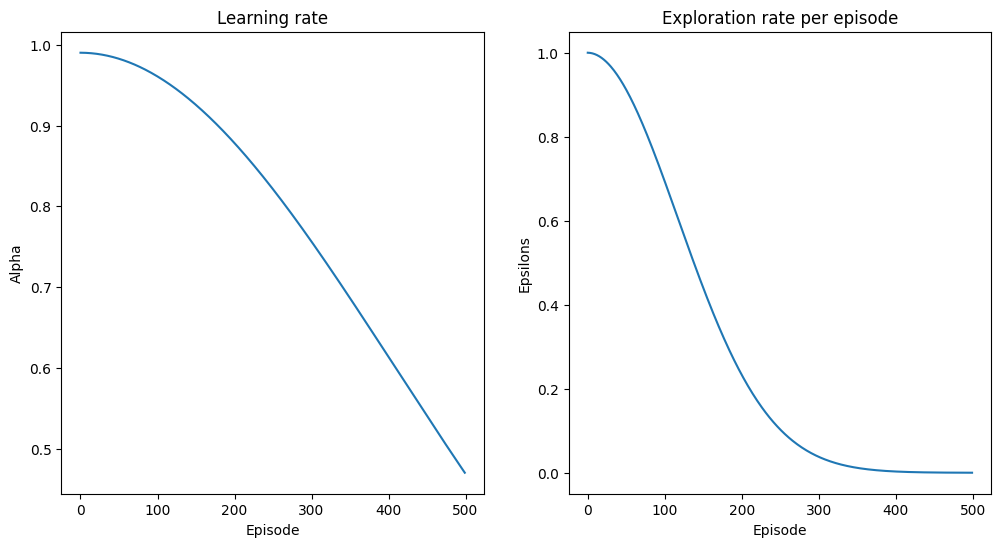

In [5]:
"Q-learning training"
env_name = 'Taxi-v3'
env = gym.make(env_name)
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Параметры
# num_episodes = 300
# gamma = 0.995 #Дисконт (забывание)


# alpha = 0.99 #LR
# alpha_decay_rate=-0.000015

# epsilon = 0.7  #коэф. исследование/использование на старте/текущий
# epsilon_decay_rate=-0.00050

# Параметры
num_episodes = 500
gamma = 0.9999 #Дисконт (забывание)


alpha = 0.99 #LR
alpha_decay_rate=-0.00000596

epsilon = 1  #коэф. исследование/использование на старте/текущий
epsilon_decay_rate=-0.0000725

# Графики
graph_rewards = []
graph_steps = []
graph_alpha = []
graph_epsilon = []
graph_noops = []
graph_pd_fails = []


# Обучение
for episode in range(num_episodes):
    state, _ = env.reset()
    step_count = 0
    terminated = truncated = False
    total_reward = 0
    no_ops = 0
    pd_fails = 0

    #for s in range(max_steps):
    while not(terminated):

        if np.random.rand() < epsilon:
            #Исследуем
            #action = env.action_space.sample(info["action_mask"])
            action = env.action_space.sample()

        else:
            #Используем
            action = np.argmax(q_table[state,:])
            #action = np.argmax(q_table[state, np.where(info["action_mask"] == 1)[0]])
        next_state, reward, terminated, truncated, info = env.step(action)
        if (next_state==state and action<4):
            reward -= 29 #Въехал в стену, чинить машину, однако, дорого
            no_ops += 1

        if reward==-10:
            reward -= 29 #Штраф от меня за остановку в неположенном месте
            pd_fails += 1
        # Обновляем таблицу
        old_value = q_table[state, action]
        new_max = np.max(q_table[next_state,:])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * new_max)

        q_table[state, action] = new_value

        state = next_state

        total_reward += reward
        step_count += 1

    epsilon = epsilon*np.exp(epsilon_decay_rate*episode)
    alpha = alpha*np.exp(alpha_decay_rate*episode)


    graph_steps.append(step_count)
    graph_rewards.append(total_reward)
    graph_epsilon.append(epsilon)
    graph_alpha.append(alpha)
    graph_noops.append(no_ops)
    graph_pd_fails.append(pd_fails)

print("\n")
print("Finished training\n")

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].set_title("Reward per episode")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Total reward")
ax[0].set_ylim([-200,30])
ax[0].plot(graph_rewards)
ax[1].set_title("Step count per episode")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Step count")
ax[1].set_ylim([0,200])
ax[1].plot(graph_steps)
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].set_title("No-ops per episode")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("No-ops")
ax[0].set_ylim([0,50])
ax[0].plot(graph_noops)
ax[1].set_title("Pick/drop fails per episode")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Pick/drop fails")
ax[1].set_ylim([0,50])
ax[1].plot(graph_pd_fails)
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].set_title("Learning rate")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Alpha")
ax[0].plot(graph_alpha)
ax[1].set_title("Exploration rate per episode")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Epsilons")
ax[1].plot(graph_epsilon)
plt.show()



Сохранение и загрузку проверил и закомментировал

In [9]:
#Save q_table
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/gdrive')
  np.save("/content/gdrive/My Drive/Colab Notebooks/q_table", q_table)
else:
  np.save("q_table", q_table)


Mounted at /content/gdrive


In [ ]:
#Load q_table
# if 'google.colab' in str(get_ipython()):
#   from google.colab import drive
#   drive.mount('/content/gdrive')
#   q_table=np.load("/content/gdrive/My Drive/Colab Notebooks/q_table.npy")
# else:
#   q_table=np.load("q_table.npy")

Тестирование обученного агента.
10000 эпизодов.
Что тут сказать.
Довольно странное поведение, но ошибку так и не нашел.
Сходимость по графикам обучения смог настроить начиная с 200 эпизодов обучения, но при проверке политики на большом количестве эпизодов, вне зависимости от красоты графика обучения наблюдаются зацикливания. От 2 до 10% эпизолдов в среднем, демонстрирует периодическое попадание агента в какие-то "субоптимальные петли". Пропадать эти петли начинают примерно при 500 эпизодах. Чтобы малым количеством эпизодов хорошо учть при такмх делах, можно наверное сделать при обучении какой нибудь буфер кольцевой и хранить в нем скажем, 5-10 последних состояний. Если очередное состояние уже есть в буфере - штрафовать. Наверное, поможет.

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


Pick-up/drop fails:0
No-ops:0


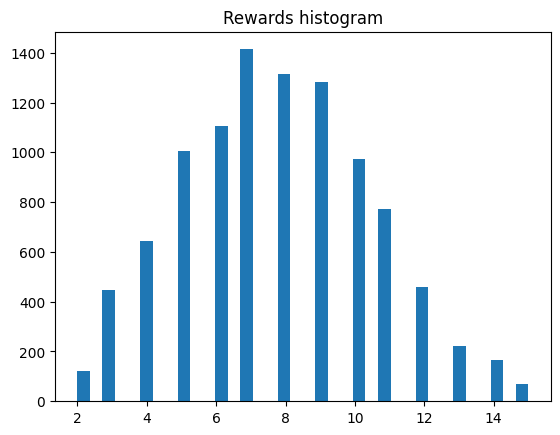

Last episode video


In [11]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_learned.mp4")

total_episodes=10000
graph_rewards = []
no_ops = 0
pd_fails = 0

for episode in range(total_episodes):
  state, _ = env.reset()
  terminated = truncated = False
  episode_reward = 0
  episode_steps = 0
  while not (terminated or truncated):
    if episode==total_episodes-1:
      frame = env.render()
      vid.capture_frame()

    action = np.argmax(q_table[state, :])
    next_state, reward, terminated, truncated, info = env.step(action)
    if (next_state==state and action<4):
        no_ops += 1

    if reward==-10:
        pd_fails += 1
    #action = np.argmax(q_table[state, np.where(info["action_mask"] == 1)[0]])
    state=next_state
    episode_reward += reward

  graph_rewards.append(episode_reward)


print(f'Pick-up/drop fails:{pd_fails}')
print(f'No-ops:{no_ops}')
#Гистограмма наград
plt.hist(graph_rewards, bins='auto')
plt.title("Rewards histogram")
plt.show()


vid.close()
env.close()

# show video
print("Last episode video")
html = render_mp4(f"video/{env_name}_learned.mp4")
HTML(html)

